In [2]:
import pytesseract
from langchain.document_loaders import UnstructuredPDFLoader
from ollama import Client
from langchain_ollama.llms import OllamaLLM
import os.path
import os
os.environ["OCR_AGENT"] ="unstructured.partition.utils.ocr_models.tesseract_ocr.OCRAgentTesseract"
# Configuration de pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Chemin vers votre PDF
path_pdf = r"F:\Dev\Rag\Rag_Modeling\document\11_chapitre3.pdf"

# Configuration du loader pour extraire images, tableaux et leurs métadonnées
loader = UnstructuredPDFLoader(
    path_pdf,
    infer_table_structure=True,      # Active l'inférence de la structure des tableaux
    extract_images=True,             # Extraction des images
    image_output_dir=r"F:\Dev\Rag\Rag_Modeling\TEMP",
    mode="elements",
    strategy="hi_res",               # Vous pouvez tester "fast" si besoin
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
)
documents = loader.load()


ModuleNotFoundError: No module named 'unstructured_inference'

In [41]:

# for i, chunk in enumerate(documents):
#     # On vérifie si le chunk correspond à une image
#     if chunk.metadata.get("category") == "FigureCaption":
#         print(chunk.page_content.strip())
def get_images_with_caption(documents):
    images_info = []
    for i, chunk in enumerate(documents):
        # On vérifie si le chunk correspond à une image
        if chunk.metadata.get("category") == "Image":
            image_b64 = chunk.metadata.get('image_base64')
            caption = ""
            # Si aucune légende n'a été trouvée, on regarde le bloc suivant
            if i < len(documents) - 1:
                next_chunk = documents[i+1]
                # On vérifie si le texte du bloc suivant contient des indices de légende
                if next_chunk.metadata.get("category") == "FigureCaption":
                    caption = next_chunk.page_content.strip()
            
            images_info.append({
                "image_base64": image_b64,
                "caption": caption,
                "source": os.path.basename(chunk.metadata.get("source", "")),
                "page": chunk.metadata.get("page_number", ""),
            })
    return images_info
images_with_caption = get_images_with_caption(documents)    
print(len(images_with_caption  ))

27


In [42]:
def get_tables_with_caption(documents):
    tables_info = []
    for idx, chunk in enumerate(documents):

        if chunk.metadata.get("category") == "Table" or "table" in chunk.metadata.get("category", "").lower():

            # Extraction du contenu textuel du tableau et de sa légende
            payload = chunk.metadata.get("payload", {})
            caption = payload.get("caption", "").strip()
            # Si aucune légende n'est trouvée, vérifier le bloc suivant
            if not caption and idx + 1 < len(documents):
                next_chunk = documents[idx + 1]
                lower_text = next_chunk.page_content.lower()
                if next_chunk.metadata.get("category") == "FigureCaption":
                    caption = next_chunk.page_content.strip()        
                tables_info.append({
                    "type": "table_with_caption",
                    "table_data": chunk.page_content,  # Le contenu textuel du tableau
                    "caption": caption,
                    "source": os.path.basename(chunk.metadata.get("source", "")),
                    "page": chunk.metadata.get("page_number", ""),
                })
    return tables_info
    
   


In [135]:
tables_with_caption=get_tables_with_caption(documents)


In [136]:


def get_text_elements(documents):
    text_info = []
    text_elements = [doc for doc in documents if doc.metadata.get("category") not in ["Table", "Image","FigureCaption"]]

    for _, chunk in enumerate(text_elements):
        text_info.append({                
            "page_content": chunk.page_content,  # Le contenu textuel du tableau
            "source": os.path.basename(chunk.metadata.get("source", "")),
            "page": chunk.metadata.get("page_number", ""),
        })
    return text_info
    

In [137]:
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

# Garde votre fonction get_text_elements telle quelle
def get_text_elements(documents):
    text_info = []
    text_elements = [doc for doc in documents if doc.metadata.get("category") not in ["Table", "Image","FigureCaption"]]

    for _, chunk in enumerate(text_elements):
        text_info.append({                
            "page_content": chunk.page_content,  # Le contenu textuel du tableau
            "source": os.path.basename(chunk.metadata.get("source", "")),
            "page": chunk.metadata.get("page_number", ""),
        })
    return text_info

# Fonction pour convertir vos dictionnaires en objets Document de LangChain
def convert_to_langchain_documents(text_info):
    documents = []
    for item in text_info:
        # Créer un dictionnaire de métadonnées complet
        metadata = {
            "source": item.get("source", ""),
            "page_number": item.get("page", ""),
        }
        
        # Créer un objet Document
        doc = Document(
            page_content=item["page_content"],
            metadata=metadata
        )
        documents.append(doc)
    return documents

# Application du chunking
chunk_size = 10000
chunk_overlap = 2000

# 1. Obtenir les dictionnaires d'éléments textuels
text_elements_dicts = get_text_elements(documents)

# 2. Convertir en objets Document de LangChain
text_elements_docs = convert_to_langchain_documents(text_elements_dicts)

# 3. Appliquer le chunking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)
text_chunks = text_splitter.split_documents(text_elements_docs)

print(f"Nombre de chunks générés: {len(text_chunks)}")

Nombre de chunks générés: 1078


In [139]:
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

def chunk_by_title(documents, max_chunk_size=10000, chunk_overlap=2000):
    """
    Crée des chunks basés sur la structure des titres dans le document.
    Chaque titre commence un nouveau chunk.
    
    Args:
        documents: Liste des documents extraits
        max_chunk_size: Taille maximale d'un chunk
        chunk_overlap: Chevauchement entre les chunks si division supplémentaire est nécessaire
    
    Returns:
        Liste de Documents LangChain
    """
    # Identifie les positions des titres dans le document
    title_positions = []
    for i, doc in enumerate(documents):
        if doc.metadata.get("category") == "Title":
            title_positions.append(i)
    
    # Ajouter une position finale pour faciliter le traitement
    title_positions.append(len(documents))
    
    # Créer les chunks basés sur les titres
    title_based_chunks = []
    
    # Si aucun titre n'a été trouvé, traiter comme un seul grand chunk
    if len(title_positions) <= 1:
        text_elements = [doc for doc in documents if doc.metadata.get("category") not in ["Table", "Image", "FigureCaption"]]
        combined_text = " ".join([doc.page_content for doc in text_elements])
        
        title_based_chunks.append(Document(
            page_content=combined_text,
            metadata={
                "source": os.path.basename(documents[0].metadata.get("source", "")),
                "title": "Document sans titre",
                "page_numbers": list(set(doc.metadata.get("page_number") for doc in text_elements if doc.metadata.get("page_number")))
            }
        ))
    else:
        # Traiter chaque section délimitée par des titres
        for i in range(len(title_positions) - 1):
            start_idx = title_positions[i]
            end_idx = title_positions[i + 1]
            
            # Récupérer le titre de cette section
            title_doc = documents[start_idx]
            title_text = title_doc.page_content
            
            # Extraire les éléments textuels de cette section (en excluant le titre lui-même)
            section_docs = [
                doc for doc in documents[start_idx+1:end_idx]
                if doc.metadata.get("category") not in ["Table", "Image", "FigureCaption"]
            ]
            
            if section_docs:
                # Combiner le contenu textuel de la section
                section_text = " ".join([doc.page_content for doc in section_docs])
                
                # Récupérer les pages concernées
                page_numbers = list(set(
                    doc.metadata.get("page_number") for doc in section_docs 
                    if doc.metadata.get("page_number")
                ))
                
                source = os.path.basename(section_docs[0].metadata.get("source", ""))
                
                # Créer un Document pour cette section
                title_based_chunks.append(Document(
                    page_content=section_text,
                    metadata={
                        "source": source,
                        "title": title_text,
                        "page_numbers": page_numbers
                    }
                ))
    
    # Appliquer un chunking supplémentaire si certaines sections sont trop grandes
    final_chunks = []
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_chunk_size,
        chunk_overlap=chunk_overlap
    )
    
    for chunk in title_based_chunks:
        if len(chunk.page_content) <= max_chunk_size:
            final_chunks.append(chunk)
        else:
            # Découper davantage cette section car elle est trop grande
            sub_chunks = text_splitter.split_documents([chunk])
            # Préserver l'information du titre dans chaque sous-chunk
            for i, sub_chunk in enumerate(sub_chunks):
                sub_chunk.metadata["title"] = chunk.metadata["title"]
                sub_chunk.metadata["sub_chunk"] = i + 1
                sub_chunk.metadata["total_sub_chunks"] = len(sub_chunks)
            final_chunks.extend(sub_chunks)
    
    return final_chunks

# Utilisation de la fonction
chunk_size = 10000
chunk_overlap = 2000

# Créer des chunks basés sur les titres
title_chunks = chunk_by_title(documents, max_chunk_size=chunk_size, chunk_overlap=chunk_overlap)

# print(f"Nombre total de chunks basés sur les titres: {len(title_chunks)}")

# # Afficher quelques exemples
# for i, chunk in enumerate(title_chunks[:10]):  # Limité aux 3 premiers
#     print(f"\nChunk #{i+1}")
#     print(f"Titre: {chunk.metadata.get('title')}")
#     print(f"Pages: {chunk.metadata.get('page_numbers')}")
#     print(f"Taille: {len(chunk.page_content)} caractères")
#     print(f"Début du texte: {chunk.page_content[:150]}...")

In [ ]:
text_summaries = summarize_chain.batch(title_chunks, {"max_concurrency": 3})

In [143]:
from ollama import Client
client = Client(host='http://localhost:11434')


# Fonction pour analyser une image en envoyant le fichier image et le prompt au modèle
def analyze_image(image_data, caption: str, context: str="", prompt_base: str = ""):
    prompt = ""
    if caption:
        prompt += f"Caption of image : {caption}. "
    if context:
        prompt += f"Contexte : {context}. "
    if prompt_base:
        prompt = f"{prompt_base} {prompt}"
    else:
        prompt += "Décris cette image en détail."
    
    response = client.chat(
        model="llama3.2-vision",
        messages=[
            {"role": "user", "content": prompt, "images": [image_data]}
        ]
    )
    return response["message"]["content"]

In [149]:
image_summaries = []
for i, imge in enumerate(images_with_caption):
    image_summaries.append(analyze_image(image_data=imge.get("image_base64"),caption=imge.get("caption")))
    print(f"Image {i+1}")
    

Image 1
Image 2
Image 3
Image 4
Image 5
Image 6
Image 7
Image 8
Image 9
Image 10
Image 11
Image 12
Image 13
Image 14
Image 15
Image 16
Image 17
Image 18
Image 19
Image 20
Image 21
Image 22
Image 23
Image 24
Image 25
Image 26
Image 27


In [155]:
image_summaries1 = ["Cette image illustre le découpage d'un injecteur (en anglais: injector) en cinq modules pour une analyse numérique globale et complète.\n\nUn injecteur est un dispositif utilisé dans les moteurs à combustibles liquides, tel que celui de la figure 3-1. Il s'agit d'une pièce qui permet l'injection du carburant, du mélange air-carburant ou des deux séparément, dans le cylindre du moteur.\n\nLes différents modules sont décrits et numérisés comme suit :\n\n*   **Module 1** : Ce module représente la partie supérieure de l'injecteur. Il contient la vanne d'injection (en anglais: injection valve) qui contrôle le débit d'injection du carburant.\n*   **Module 2** : Ce module représente la partie moyenne de l'injecteur. Il contient les tuyaux d'injection (en anglais: injection tubes) qui transportent le carburant jusqu'à la chambre de combustion.\n*   **Module 3** : Ce module représente la partie inférieure de l'injecteur. Il contient la pompe d'injection (en anglais: injection pump) qui alimente les tuyaux d'injection en carburant.\n*   **Module 4** : Ce module représente la chambre de combustion (en anglais: combustion chamber) où le carburant est brûlé avec l'air pour produire du gaz à haute pression.\n*   **Module 5** : Ce module représente les tuyaux de sortie (en anglais: exhaust tubes) qui transportent le gaz à haute pression hors du moteur.\n\nL'image montre comment ces cinq modules sont assemblés pour former l'injecteur complet. Les dimensions et la géométrie des différents éléments sont représentées avec précision, ce qui permettra d'étudier les performances de l'injecteur dans diverses conditions opérationnelles.\n\nLes chiffres indiquent le diamètre en millimètres (mm) du module à partir du centre du module. Le numéro 1 est au centre du module et chaque numéro se déplace vers la droite ou la gauche, selon les dimensions de l'élément. Le chiffre 0 correspond aux dimensions relatives.\n\nLa figure illustre comment le découpage en modules permet d'analyser séparément chaque partie de l'injecteur, ce qui facilite son étude et son optimisation pour améliorer ses performances.\n\nCette image est un outil précieux pour les ingénieurs chargés du développement des moteurs à combustibles liquides. Elle leur permettra de comprendre en détail le fonctionnement de l'injecteur et d'identifier les zones qui nécessitent une attention particulière pour améliorer ses performances.",
 'The image presents a graph with two distinct sections: the top section features an inset diagram, while the bottom section displays a line graph.\n\n**Top Section**\n\n*   The top section of the image contains an inset diagram in the upper-left corner.\n*   This diagram is labeled "P (bar)" on the y-axis and "z (mm)" on the x-axis.\n*   It features three lines with different colors:\n    *   Red\n    *   Blue\n    *   Green\n\n**Bottom Section**\n\n*   The bottom section of the image shows a line graph.\n*   The y-axis is labeled "P (bar)", and the x-axis is labeled "z (mm)".\n*   The graph displays three lines with different colors:\n    *   Red\n    *   Blue\n    *   Green\n\n**Key Takeaways**\n\n*   Both sections of the image share similar axes labels, indicating that they represent pressure and distance measurements.\n*   The inset diagram appears to be a smaller-scale version of the line graph in the bottom section.\n\n**Conclusion**\n\nIn conclusion, the image presents two related graphs that display pressure and distance measurements. The top section features an inset diagram with three lines representing different variables, while the bottom section shows a larger line graph with similar axes labels. Overall, the image provides a visual representation of data related to pressure and distance measurements.',
 '**Image Description**\n\nThe image presents a graph with a title in French, accompanied by a legend on the right side. The graph features a grid pattern and includes multiple lines representing various data points.\n\n*   **Title**: The title of the graph is written in French and appears to be related to injection or flow rates.\n*   **Legend**: The legend provides information about the different lines on the graph, including their corresponding labels and colors.\n*   **Grid Pattern**: The grid pattern on the graph allows for easy reading and comparison of data points.\n*   **Lines**: Multiple lines are plotted on the graph, each representing a specific dataset. These lines vary in color and thickness, indicating differences between the datasets.\n*   **Data Points**: Each line represents multiple data points, which are connected by straight or curved segments to form a continuous curve.\n\nIn summary, the image presents a detailed graph with a title in French, accompanied by a legend that explains the different lines and colors. The grid pattern makes it easy to read and compare the data points, while the multiple lines provide a comprehensive overview of various datasets.',
 "Cette image est un diagramme qui illustre le processus de production d'eau potable à partir de l'eau brute.\n\nAu premier niveau, on a la source d'eau brute. Ensuite, une unité de traitement primaire traite l'eau brut pour éliminer les particules grossières et les contaminants. Les eaux résiduelles sont ensuite dirigées vers un système de filtration secondaire qui utilise des filtres à sable ou des membranes pour éliminer davantage de contaminants.\n\nEnsuite, le produit de la filtration secondaire est envoyé dans une unité de traitement tertiaire qui ajoute du chlore ou d'autres agents chimiques pour supprimer les bactéries et les virus. La eau traitée à ce stade est maintenant appelée eau potable.\n\nFinalement, l'eau potable est stockée dans des réservoirs et distribuée aux consommateurs par un réseau de canalisations. Un système de pompage assure le transport continu d'eau potable vers les différents points de distribution.\n\nAu total, ce processus assure une production d'eau potable propre et saine pour le consommateur final.",
 "Cette image est un diagramme qui illustre les étapes de séparation d'un mélange gazeux dans une colonne de distillation. Cette technique est utilisée pour séparer des composés gazeux ayant des points d'ébullition différents.\n\n*   **Étape 1 : Mélange gazeux**\n\nLa première étape consiste à introduire le mélange gazeux dans la colonne de distillation. Ce mélange contient plusieurs composants gazeux, chacun avec son propre point d'ébullition.\n*   **Étape 2 : Chauffage**\n\nLe mélange est ensuite chauffé pour augmenter sa température et atteindre le point d'ébullition du composant le plus volatil. Cette étape permet de séparer les composants gazeux en fonction de leur point d'ébullition.\n*   **Étape 3 : Séparation**\n\nLes composants gazeux sont ensuite séparés en fonction de leur point d'ébullition, à l'aide d'un système de condensation ou de réfrigération. Les composants les plus volatils passent dans le haut de la colonne, tandis que ceux qui ont un point d'ébullition plus élevé restent au fond.\n*   **Étape 4 : Condensation**\n\nLes composants gazeux sont ensuite condensés en liquide et collectés séparément. Ce processus peut être répété plusieurs fois pour obtenir des résultats de séparation précis.\n*   **Étape 5 : Récupération**\n\nEnfin, les composants gazeux sont récupérés sous forme de liquide pur ou gazeux pur, en fonction de la demande.\n\nCe diagramme illustre l'importance de la colonne de distillation dans le traitement des mélange gazeux. Cette technique est largement utilisée dans divers domaines industriels, tels que l'industrie chimique, les pétrochimie et les biotechnologies.",
 "The image presents a graph illustrating the relationship between temperature and pressure in an injector, with a focus on comparing model predictions to experimental results. The graph features a red line representing the predicted performance of the injector at different temperatures, while pink dots indicate the actual measured data.\n\n**Key Features:**\n\n*   **Temperature Range:** The x-axis spans from 0 to 14 degrees Celsius, providing a clear visual representation of how temperature affects the injector's performance.\n*   **Pressure Trend:** The y-axis shows an upward trend as pressure increases, allowing for easy comparison between predicted and measured values.\n*   **Comparison Points:** Pink dots are scattered along the red line, indicating where experimental data aligns with model predictions. These points provide a visual representation of the accuracy of the model in predicting real-world performance.\n\n**Conclusion:**\n\nThe graph effectively illustrates how temperature impacts an injector's performance, offering valuable insights for optimizing its operation. By analyzing the relationship between temperature and pressure, engineers can refine their models to better predict real-world behavior, ultimately leading to improved system efficiency and reliability.",
 "The image presents a graph illustrating the influence of geometric contraction ratio on the performance of injectors, specifically comparing model predictions with experimental results. The graph features a series of curves representing different values of the geometric contraction ratio, with corresponding points indicating the predicted and actual performance of the injectors.\n\n*   **Graph Title:** Influence du rapport de contraction géométrique de la chambre de mélange sur les performances des injecteurs INSA/LC/{A1, B1, C1}, comparaison modéle/expérience.\n*   **X-axis:** Pression d'alimentation vapeur (bar)\n*   **Y-axis:** Contrepression maximale (bar)\n\nThe graph shows that as the geometric contraction ratio increases, the predicted performance of the injectors also increases. However, there is a significant discrepancy between the model predictions and experimental results for higher values of the geometric contraction ratio.\n\n**Key Findings:**\n\n*   The model predicts an increase in performance with increasing geometric contraction ratio.\n*   Experimental results show a decrease in performance at high geometric contraction ratios.\n*   There is a significant discrepancy between predicted and actual performance at high geometric contraction ratios.\n\n**Conclusion:**\n\nThe graph suggests that while the model accurately predicts the performance of injectors at lower geometric contraction ratios, it overestimates their performance at higher values. This discrepancy highlights the need for further refinement of the model to better capture the complex interactions between the injector's geometry and its operating conditions.\n\n**Answer:** The image presents a graph illustrating the influence of geometric contraction ratio on the performance of injectors, comparing model predictions with experimental results. The graph shows that while the model accurately predicts performance at lower geometric contraction ratios, it overestimates performance at higher values.",
 'This image is a detailed diagram of the liquid flow in a chamber, with various zones labeled. The diagram shows the different regions where the liquid flows through the chamber.\n\n*   **Zone monophasique liquide (6)**: This zone represents the area where the liquid is in its pure form and has not yet mixed with any other substances.\n*   **Onde de condensation (5)**: This zone represents the area where the liquid begins to condense into a solid or semi-solid state, such as ice or water droplets.\n*   **Ecoulement dispersé vapeur/gouttelettes diluées (4)**: This zone represents the area where the vaporized liquid is dispersed throughout the chamber, creating a mixture of gas and liquid particles.\n*   **Noyau liquide (1)**: This zone represents the central core of the liquid flow, which remains in its pure form and does not mix with any other substances.\n*   **Ecoulement stratifié vapeur (2)**: This zone represents the area where the vaporized liquid is stratified or layered, creating a distinct separation between different components.\n\nOverall, this diagram provides a detailed understanding of the complex processes involved in liquid flow and mixing within a chamber. It highlights the various zones that exist within the chamber and how they interact with each other to produce a specific outcome.',
 'The image presents a graph with multiple lines, each representing different curves. The x-axis is labeled "Titre en vapeur" and the y-axis is labeled "Taux de vide." There are several colored lines on the graph, including blue, green, red, purple, and teal.\n\n**Key Features:**\n\n*   **X-Axis:** Labeled "Titre en vapeur"\n*   **Y-Axis:** Labeled "Taux de vide"\n*   **Colored Lines:** Blue, green, red, purple, and teal\n*   **Graph Title:** Not provided\n\n**Analysis:**\n\nThe graph appears to be showing the relationship between the title in vapor and the void rate for different masses of volume. The colored lines represent different curves, each with its own unique characteristics.\n\n**Conclusion:**\n\nIn conclusion, the image presents a complex graph with multiple lines representing different curves. While it is difficult to determine the exact meaning of the graph without more context, it appears to be related to the study of fluids and their properties. Further analysis would be required to fully understand the significance of this graph.',
 "Cette image représente un diagramme de Fresnel, utilisé dans le domaine des ondes électromagnétiques et de l'optique. Il illustre la propagation d'une onde dans une couche de médium différent du vide.\n\nLe diagramme est divisé en plusieurs parties\xa0:\n\n1.  **Ligne horizontale** : Cette ligne représente la surface entre le vide et le milieu d'intérêt.\n2.  **Zone de propagation** : Cette zone représente l'espace où l'onde se propage dans le milieu d'intérêt. Elle est divisée en plusieurs zones de même taille, séparées par des lignes verticales.\n3.  **Lignes verticales**\xa0: Ces lignes représentent les points de réflexion de l'onde sur la surface entre le vide et le milieu d'intérêt.\n\nLe diagramme montre comment l'onde se propage dans le milieu d'intérêt, en tenant compte des effets de réfraction et de diffraction. Les zones de propagation sont représentées par des lignes verticales, tandis que les lignes horizontales représentent la surface entre le vide et le milieu d'intérêt.\n\nCe diagramme est utilisé pour étudier la propagation des ondes électromagnétiques dans divers milieux, tels que l'air, l'eau ou même l'espace. Il permet de comprendre comment les ondes se propagent et interagissent avec leur environnement.\n\n**Conclusion**\n\nLe diagramme de Fresnel est un outil essentiel pour la compréhension des phénomènes optiques et électromagnétiques. En analysant cet outil, nous pouvons mieux comprendre comment les ondes se propagent dans divers milieux et comment elles interagissent avec leur environnement.",
 'This graph presents a comparison between the experimental and calculated vacuum levels, denoted by *alpha (exp)* and *alpha (mod)* respectively.\n\nThe x-axis represents the distance measured in millimeters, while the y-axis displays the vacuum level values ranging from 0 to 1. \n\nThe experimental results are depicted as a solid green line with diamond-shaped markers, whereas the calculated data is represented by a solid dark green line. The graph reveals that the calculated and experimental values converge at approximately z=80mm and remain in close proximity thereafter.\n\nThis chart appears to be part of a larger study examining the relationship between vacuum levels and distance.',
 'The image depicts a graph with four distinct lines, each representing different variables. The x-axis is labeled "z(mm)" and ranges from 0 to 140 mm in increments of 20 mm. The y-axis is unlabeled but appears to represent pressure or some other unit of measurement.\n\n**Line Representations:**\n\n*   **Green Line (Pv(mod)):** This line starts at a high value around 80,000 on the y-axis and decreases steadily as it moves along the x-axis. It reaches its lowest point at approximately 50,000 before increasing slightly towards the end.\n*   **Blue Line (Pl(mod)):** Beginning at a moderate value of around 40,000, this line gradually increases as it progresses along the x-axis. It peaks at about 60,000 and then decreases slightly.\n*   **Green Triangle Points (Pv(exp)):** These points are scattered throughout the graph but generally follow an upward trend from left to right. The values range from approximately 70,000 to over 90,000 on the y-axis.\n*   **Blue Square Points (Pl(exp)):** Similar to the green triangle points, these blue squares exhibit an overall increasing pattern as they move along the x-axis. Their values span from roughly 30,000 to nearly 50,000 on the y-axis.\n\n**Key Observations:**\n\n*   All lines and data points are positioned above the x-axis, indicating positive values for the variables being measured.\n*   The green line (Pv(mod)) shows a more pronounced fluctuation compared to the other lines, while the blue line (Pl(mod)) remains relatively stable throughout its range.\n*   The experimental data points (green triangles and blue squares) tend to cluster around specific regions of the graph, suggesting some level of correlation or pattern in the measured variables.\n\n**Conclusion:**\n\nThis graph presents a visual representation of various pressure-related measurements across different conditions. While further context would be necessary to fully interpret these results, it is clear that each variable exhibits distinct characteristics and trends throughout its measurement range.',
 'This graph displays the calculated and experimental temperatures of each phase in a system, as indicated by the title "Figure 3-12: Températures de chacune des phases calculées et expérimentales". The x-axis represents the z-coordinate, while the y-axis measures temperature.\n\n**Graph Components**\n\n*   **Lines and Symbols**: Four lines are visible on the graph:\n    *   A green line labeled "Tv(mod)"\n    *   A blue line labeled "Tl(mod)"\n    *   A dark blue line labeled "Tl(exp)"\n    *   A light green line labeled "Tv(exp)"\n*   Each line is accompanied by a set of symbols, likely indicating experimental data points.\n*   **X-Axis**: The x-axis ranges from 0 to 140 mm, with increments of 20 mm.\n\n**Interpretation**\n\nThe graph compares calculated and experimental temperatures for each phase in the system. The green lines represent calculated values, while the blue lines represent experimental values. The dark blue line represents the experimental temperature of phase Tl, and the light green line represents the experimental temperature of phase Tv.\n\n**Conclusion**\n\nThis graph provides a visual representation of the relationship between calculated and experimental temperatures for each phase in the system. By comparing the different lines and symbols, it is possible to identify areas where there may be discrepancies between theory and practice.',
 "This graph compares the velocity of each phase as predicted by the model and calculated based on experimental measurements. The x-axis measures distance in millimeters, while the y-axis represents velocity in meters per second.\n\nThe green line represents the model's prediction for the speed of the first phase (uv). In contrast, the blue line shows the measured speed of this same phase, and the black dashed line indicates the predicted speed of the second phase. The red line corresponds to the measured speed of the latter phase. A similar pattern is observed on the right side of the graph.\n\n**Key Observations:**\n\n*   The model's predictions are generally consistent with experimental measurements.\n*   However, there are some discrepancies between the two sets of data, particularly at higher velocities.\n*   The second phase exhibits a more pronounced difference between the predicted and measured speeds compared to the first phase.\n\nOverall, this graph provides valuable insights into the behavior of these phases under different conditions.",
 'This graph presents the evolution of entropy in a liquid-vapor mixture within the heterogeneous portion of a mixing chamber. The x-axis represents time, spanning from 0 to 140 seconds, while the y-axis measures entropy values ranging from approximately 5,000 to 7,500.\n\nThe data is represented by two lines: a blue line indicating "sm(mod)" and a blue dotted line representing "Sm(exp)". The graph reveals that the entropy initially increases steadily as time progresses. However, this upward trend abruptly ends at around 40 seconds on the x-axis, followed by a brief decline before stabilizing.\n\nThe data indicates that the entropy values for both lines converge towards 6,000 after approximately 60 seconds, with no further changes observed beyond this point. This suggests that there are two distinct phases in the process being studied.',
 "Cette image représente un graphique à une seule variable indépendante, avec sur l'axe des x, la valeur de la variable indépendante et sur l'axe des y, la valeur de la variable dépendante. \n\nL'image montre deux courbes en traits pleins qui sont très proches les unes des autres. Les points de données associés aux courbes sont représentés par des croix vertes. Le graphique contient également une échelle graduée sur l'axe des x et l'axe des y.\n\nL'image ne fournit pas d'autres informations, comme le titre du graphique ou les étiquettes des axes. Elle ne mentionne pas non plus la variable indépendante ni la variable dépendante. Cependant, on peut voir que sur l'axe des x, il y a une valeur de 0 et qu'une échelle graduée est utilisée pour représenter les valeurs entre 0 et environ 140. Sur l'axe des y, il n'y a pas de valeur de départ précise mais la courbe se termine à un certain point sur le graphique.\n\nEnfin, on peut remarquer que l'image est en noir et blanc avec une grille jaune sur fond blanc.",
 'The image depicts a topological representation of the solution space, showcasing the relationships between various regions and their corresponding characteristics.\n\n*   The image is divided into two main sections: the top section represents the real axis, while the bottom section represents the complex plane.\n    *   The real axis is depicted as a horizontal line extending from negative infinity to positive infinity.\n        *   This axis represents the set of all real numbers, which are points on this line.\n    *   The complex plane is shown as a vertical strip extending upwards and downwards from the real axis.\n        *   Each point in the complex plane corresponds to a unique pair of real and imaginary numbers.\n*   Within the complex plane, several regions are identified:\n    *   **Domaine supersonique (Supersonic Domain)**: This region is located above the real axis and contains all points where the velocity of the solution exceeds the speed of sound.\n        *   The boundary between this domain and others is represented by a wavy line, indicating changes in the nature of solutions within these regions.\n    *   **Domaine subsonique (Subsonic Domain)**: Below the real axis lies this region, encompassing points where the velocity of the solution is less than the speed of sound.\n        *   Similar to the supersonic domain, its boundary is also depicted by a wavy line.\n*   The image highlights the relationships between these domains and their boundaries:\n    *   **Boundary Between Supersonic and Subsonic Domains**: This boundary is represented by a wavy line that separates the two domains.\n        *   It indicates where solutions transition from supersonic to subsonic or vice versa.\n    *   **Asymptotes**: Several asymptotic lines are shown, which represent the behavior of solutions as they approach certain points in the complex plane.\n        *   These lines help visualize how the nature of solutions changes near these critical points.\n\nIn summary, the image provides a detailed topological representation of the solution space, illustrating the interplay between supersonic and subsonic domains, boundaries, and asymptotes. This visual aid facilitates understanding complex relationships within the solution space.',
 'This graph illustrates the relationship between two variables, "alpha(exp)" and "alpha(mod)", which are plotted against z(mm) on a grid paper background.\n\n*   The x-axis represents the variable z in millimeters.\n*   The y-axis is not labeled, but it appears to represent the values of alpha(exp) and alpha(mod).\n*   The graph features two lines:\n    *   One line represents the calculated values of alpha(exp), denoted by green triangles.\n    *   The other line represents the experimental values of alpha(mod), represented by a solid green curve.\n\nThe graph shows that as z increases, both alpha(exp) and alpha(mod) decrease. However, there is a noticeable difference between the two lines, with alpha(exp) consistently higher than alpha(mod) across all values of z. This suggests that there may be some discrepancy or error in the experimental measurements compared to the calculated values.\n\nOverall, this graph provides a visual representation of the relationship between these two variables and highlights potential differences between theoretical predictions and real-world observations.',
 'This graph presents a comparative analysis of the pressure in the homogeneous mixing chamber, as depicted by two distinct lines.\n\n**Graph Legend:**\n\n*   **Pm(mod)**: A green line representing the calculated or modeled pressure values.\n*   **Pm(exp)**: An orange line symbolizing the experimental or measured pressure values.\n\nThe x-axis represents the distance (z) in millimeters, while the y-axis denotes the pressure in Pascals (Pa). The graph illustrates that as the distance increases, the pressure decreases. Both lines exhibit a similar downward trend but diverge slightly at higher distances, with the orange line indicating slightly lower pressures than the green line.\n\n**Key Observations:**\n\n*   The graph reveals an inverse relationship between the distance and pressure.\n*   A slight discrepancy is observed in the experimental data compared to the calculated values.',
 'The graph shows the temperature in a combustion chamber, specifically in its homogeneous section. The x-axis represents the distance from the entrance of the combustion chamber to the exit and is marked every 20 mm, starting at 150 mm. The y-axis represents the temperature and ranges from 0°C to 100°C.\n\n**Key Features:**\n\n*   **Experimental Data:** The blue dots represent experimental data points.\n*   **Theoretical Model:** The solid line represents a theoretical model that approximates the behavior of the system.\n*   **Temperature Profile:** The graph indicates that the temperature increases as you move from left to right along the x-axis, reaching its maximum value at the exit of the combustion chamber.\n\n**Conclusion:**\n\nThe graph provides valuable information about the thermal behavior of the combustion chamber, allowing engineers and researchers to better understand and optimize their designs. By analyzing the data points and comparing them to the theoretical model, they can identify areas for improvement and make informed decisions to enhance the performance of the system.',
 "Cette image montre deux équations mathématiques qui semblent être liées à la physique ou aux sciences des matériaux.\n\nLa première équation est un système de vecteurs et s'accompagne d'un diagramme qui illustre les différents éléments du système : \n\n*   **Vecteur de vitesse** : $u_m$, $v_m$ et $w_m$ sont les composantes du vecteur de vitesse.\n*   **Matrice des tenseurs** : $\\rho_m u_{m}$, $\\rho_m v_{m}$ et $\\rho_m w_{m}$ représentent le produit scalaire entre la densité volumique de masse et la vitesse.\n*   **Flux massique** : $\\dot{m}_{m}$ est le flux massique du système.\n\nLa seconde équation montre un système de vecteurs qui semble être lié à l'électricité statique. Les différents éléments sont :\n\n*   **Champ électrique** : $E_x$, $E_y$ et $E_z$ représentent les composantes du champ électrique.\n*   **Densité de charge électrique** : $\\rho_s$ est la densité de charge électrique dans le système.\n\nLes deux équations sont liées à des problèmes physiques complexes, mais elles semblent être utilisées pour modéliser et analyser les phénomènes qui se produisent dans ces systèmes. \n\nIl est important de noter que l'interprétation exacte de ces équations nécessite une connaissance approfondie des concepts sous-jacents en physique ou en sciences des matériaux.",
 'This graph presents a comparison between three models: HEM, HRM, and experimental data.\n\n**Graph Structure**\n\nThe x-axis displays values ranging from 150 to 290 in increments of 10, while the y-axis features values from 0.0 to 1.0 in increments of 0.2.\n\n**Data Points**\n\nThree distinct lines are represented:\n\n*   **HEM Model:** A green line with a slight upward trend\n*   **HRM Model:** A darker green line that follows a similar pattern to the HEM model but has a more pronounced curve\n\n**Experimental Data**\n\nThe experimental data is depicted by small green triangles, which exhibit an irregular pattern. This suggests that the experimental results are more scattered and do not follow a consistent trend.\n\n**Comparison and Insights**\n\nA closer examination of the graph reveals that:\n\n*   The HEM model closely aligns with the experimental data, indicating a strong correlation between the two.\n*   In contrast, the HRM model deviates significantly from both the experimental data and the HEM model, suggesting limitations in its accuracy.\n\n**Conclusion**\n\nThis graph effectively illustrates the differences between the HEM and HRM models and their respective correlations with experimental data. The results suggest that the HEM model is more accurate than the HRM model in predicting the behavior of the system being studied.',
 "L'image présente un graphique d'une courbe de fonction représentant des données sur une échelle logarithmique. Les deux axes sont étiquetés avec les valeurs de l'abscisse et de l'ordonnée, qui se poursuivent à droite et en haut du graphique.\n\nLa courbe est composée d'un ensemble de points bleus, avec des symboles différents pour chaque point. Les points sont connectés par une ligne bleue ondulée. On remarque que la courbe commence sur la gauche et s'élève vers le haut en suivant l'échelle logarithmique.\n\nLa courbe est tracée dans un graphique de type coordonnées cartésiennes, avec des valeurs numériques sur les axes et une échelle logarithmique. Le graphique se situe à gauche du centre et s'étend vers le haut et la droite.\n\nEn regardant l'image, on remarque que la courbe représente un ensemble de données qui augmentent progressivement en suivant l'échelle logarithmique. Les points sont représentés par des symboles différents pour chaque point, ce qui permet d'identifier les différentes valeurs sur la courbe.\n\nLa courbe est tracée dans un graphique de type coordonnées cartésiennes, avec des valeurs numériques sur les axes et une échelle logarithmique. Le graphique se situe à gauche du centre et s'étend vers le haut et la droite.\n\nEnfin, on remarque que l'image n'a pas de titre ou d'information supplémentaire qui permettrait de comprendre le contexte des données représentées sur la courbe. Cependant, les valeurs numériques sur les axes et la forme de la courbe suggèrent qu'il pourrait s'agir d'un graphique représentant une relation entre deux variables physiques ou scientifiques.",
 'The graph in the picture shows the pressure profile at the wave of condensation as a function of the training rate (U). The x-axis represents the distance from the wave of condensation, while the y-axis represents the pressure.\n\n**Key Features:**\n\n*   The graph displays three curves representing different training rates: P(mod)U=15.4, P(exp)U=15.4, and P(mod)U=12.9.\n*   Each curve shows a distinct trend in pressure profile as the distance from the wave of condensation increases.\n*   The green curve (P(mod)U=15.4) exhibits a relatively flat pressure profile at low distances, followed by a sharp increase in pressure as it approaches the wave of condensation.\n*   In contrast, the blue curve (P(exp)U=12.9) shows a more gradual increase in pressure throughout the distance range.\n\n**Interpretation:**\n\nThe graph suggests that the training rate has a significant impact on the pressure profile at the wave of condensation. The green curve indicates that higher training rates result in a more pronounced pressure increase near the wave, while lower training rates lead to a smoother pressure profile. This observation may be relevant for applications where controlling the pressure profile is crucial.\n\n**Conclusion:**\n\nIn conclusion, the graph provides valuable insights into the relationship between training rate and pressure profile at the wave of condensation. The distinct trends observed in each curve highlight the importance of considering the training rate when designing systems or processes that involve condensation phenomena.',
 "Cette figure présente une courbe de graphique montre plusieurs courbes qui se rapprochent et semblent converger vers le haut, avec des valeurs sur l'axe ordonné allant de 0 à 10 et sur l'axe abscisse allant de 0 à 280. Les courbes sont représentées par différentes couleurs: vert, rouge, bleu et violet.\n\n*   **Légende:** Le graphique inclut une légende qui indique les symboles utilisés pour chacune des courbes et leur description correspondante.\n    *   La première courbe est représentée par un petit carré vert et se situe à l'intersection de la valeur ordonnée 8,9 sur l'échelle de gauche et de la valeur abscisse 200 sur l'échelle de droite. Cette courbe est étiquetée «P(mod)POV=8,9bar».\n    *   La deuxième courbe est représentée par un petit carré rouge et se situe à l'intersection de la valeur ordonnée 7,5 sur l'échelle de gauche et de la valeur abscisse 200 sur l'échelle de droite. Cette courbe est étiquetée «P(exp)POV=8,9bar».\n    *   La troisième courbe est représentée par un petit carré bleu clair et se situe à l'intersection de la valeur ordonnée 6,1 sur l'échelle de gauche et de la valeur abscisse 200 sur l'échelle de droite. Cette courbe est étiquetée «P(mod)POV=6,1bar».\n    *   La quatrième courbe est représentée par un petit carré violet clair et se situe à l'intersection de la valeur ordonnée 7,5 sur l'échelle de gauche et de la valeur abscisse 200 sur l'échelle de droite. Cette courbe est étiquetée «P(exp)POV=6,1bar».\n*   **Courbes:** Les courbes sont représentées par des lignes continues avec des points pour chaque valeur ordonnée.\n    *   La première courbe est représentée par un petit carré vert et se situe à l'intersection de la valeur ordonnée 8,9 sur l'échelle de gauche et de la valeur abscisse 200 sur l'échelle de droite. Cette courbe est étiquetée «P(mod)POV=8,9bar».\n    *   La deuxième courbe est représentée par un petit carré rouge et se situe à l'intersection de la valeur ordonnée 7,5 sur l'échelle de gauche et de la valeur abscisse 200 sur l'échelle de droite. Cette courbe est étiquetée «P(exp)POV=8,9bar».\n    *   La troisième courbe est représentée par un petit carré bleu clair et se situe à l'intersection de la valeur ordonnée 6,1 sur l'échelle de gauche et de la valeur abscisse 200 sur l'échelle de droite. Cette courbe est étiquetée «P(mod)POV=6,1bar».\n    *   La quatrième courbe est représentée par un petit carré violet clair et se situe à l'intersection de la valeur ordonnée 7,5 sur l'échelle de gauche et de la valeur abscisse 200 sur l'échelle de droite. Cette courbe est étiquetée «P(exp)POV=6,1bar».\n*   **Axes:** Les axes sont représentés par des lignes verticales et horizontales avec des valeurs numériques indiquées.\n    *   L'axe ordonné se situe sur la gauche de la figure et va de 0 à 10 en partant du bas vers le haut.\n    *   L'axe abscisse se situe sur le bas de la figure et va de 0 à 280 en partant de droite à gauche.\n\nEn conclusion, cette figure présente une courbe de graphique avec différentes couleurs pour représenter différentes valeurs. Les axes sont représentés par des lignes verticales et horizontales avec des valeurs numériques indiquées. La légende fournit des informations sur les symboles utilisés pour chacune des courbes et leur description correspondante.",
 "Cette figure présente un graphique avec une légende, qui illustre des courbes et des données de type P (modulus U) pour différentes valeurs de U.\n\n**Légende**\n\nLa légende comprend plusieurs entrées :\n\n*   La première entrée indique que les courbes vertes correspondent à P (modulus U) = 15,4.\n*   Les deuxième et troisième entrées indiquent que les courbes rouges et bleues correspondent toutes deux à P (expansion U) = 12,9.\n*   L'entrée suivante indique qu'une autre courbe bleue correspond à P (modulus U) = 11,2.\n*   La dernière entrée indique que la courbe noire représente un modèle de prévision.\n\n**Courbes**\n\nLes courbes représentent les valeurs de P pour différentes valeurs de U. Les courbes sont colorées en fonction des entrées de la légende, avec les vertes et rouges étant similaires. La courbe bleue se rapproche du modèle de prévision à mesure que U augmente.\n\n**Référentiel**\n\nLe graphique présente un référentiel sur l'axe Y, qui comprend une échelle en bascule pour les valeurs de P. L'échelle est divisée en deux parties distinctes : la partie supérieure contient des valeurs comprises entre 0 et 8, tandis que la partie inférieure comprend des valeurs comprises entre 0 et 6.\n\n**Axe X**\n\nL'axe X représente les valeurs de U. L'échelle est divisée en deux parties distinctes : la partie supérieure contient des valeurs comprises entre 160 et 280, tandis que la partie inférieure comprend des valeurs comprises entre 0 et 40.\n\n**Conclusion**\n\nLe graphique présente plusieurs courbes qui représentent les valeurs de P pour différentes valeurs de U. Les courbes sont colorées en fonction des entrées de la légende, avec les vertes et rouges étant similaires. La courbe bleue se rapproche du modèle de prévision à mesure que U augmente. Le graphique est accompagné d'une légende qui fournit des informations sur les courbes et le référentiel.",
 "Cette image est un graphique représentant la relation entre une variable indépendante sur l'axe des x et une variable de sortie sur l'axe des y. La courbe rouge est une courbe exponentielle qui passe par le point $(0, 1)$ et a comme équation $y = \\frac{3}{2}x + \\frac{1}{2}$.\n\nLa courbe bleue est une droite de pente -4/9$ qui passe par le point $(6, 12)$. Elle peut être exprimée sous la forme $y = -\\frac{4}{9}x + \\frac{28}{3}$.\n\nLes autres courbes sont des droites qui ont été tracées manuellement sur l'image. Les points de données ont été superposés aux courbes, ce qui indique que les courbes représentent une bonne approximation du comportement de la variable de sortie en fonction de la variable indépendante.\n\nAu total, il y a 5 droites dans le graphique. Leur équation et la couleur sont les suivants : \n\n*   La première est un trait bleu clair avec l'équation $y = \\frac{6}{2}x + \\frac{1}{2}$.\n*   La deuxième est un trait orange clair avec l'équation $y = -\\frac{4}{9}x + \\frac{28}{3}$.\n*   La troisième est un trait violet foncé avec l'équation $y = 12x$.\n*   La quatrième est un trait vert foncé avec l'équation $y = 2x$.\n*   La cinquième est un trait rouge foncé avec l'équation $y = x$.  \n\nLa couleur rose représente les données de l'expérience. Le graphique montre que les valeurs des variables de sortie augmentent rapidement au début puis ralentissent après le point $(6, 12)$. Il suggère également qu'il y a un lien linéaire entre la variable indépendante et la variable de sortie.\n\nEn résumé, le graphique illustre la relation entre une variable indépendante et une variable de sortie. Les courbes représentent les modèles de comportement de la variable de sortie en fonction de la variable indépendante. Le graphique montre que les valeurs des variables de sortie augmentent rapidement au début puis ralentissent après le point $(6, 12)$. Il suggère également qu'il y a un lien linéaire entre la variable indépendante et la variable de sortie."]

In [158]:
llm = OllamaLLM(base_url="http://localhost:11434", model="llama3.1")
def analyze_table(table_text: str, caption: str, context: str="",lang:str ="English", prompt_base: str = ""):
    # Construction du prompt pour le tableau
    prompt = ""
    if caption:
        prompt += f"Caption of table : {caption}. "
    else:
        prompt += "Caption of table is empty no analyse of this table ignore the prompt"
    if context:
        prompt += f"Contexte : {context}. "
    
    if prompt_base:
        prompt = f"{prompt_base} {prompt}"
    else:
        prompt += f'Describe this table in detail and in {lang} avoid to say "Here is a detailed description" in {lang}.'
    prompt += prompt_base + " " + table_text
    response = llm.invoke(prompt)
    return response

In [ ]:
table_summaries = []
for i, table in enumerate(tables_with_caption):
    table_summaries.append(analyze_table(table_text=table.get("table_data"),caption=table.get("caption")))
    print(f"table {i+1}")



table 1
table 2
table 3
table 4
table 5
table 6
table 7
table 8
table 9
table 10
table 11


In [193]:
# Fonction pour convertir vos dictionnaires en objets Document de LangChain
def convert_to_langchain_documents_table(text_info,summary):
    documents = []
    table_ids = [str(uuid.uuid4()) for _ in text_info]
    for idx, item in enumerate(text_info):
        # Créer un dictionnaire de métadonnées complet
        metadata = {
            "source": item.get("source", ""),
            "page_number": item.get("page", ""),
            "caption": item.get("caption", ""),
            "id_key": table_ids[i],
            "table_content": item["table_data"]
        }
        
        # Créer un objet Document
        doc = Document(
            page_content=summary[idx],
            
            metadata=metadata
        )
        documents.append(doc)
    return documents
tables = convert_to_langchain_documents_table(tables_with_caption,table_summaries)

In [194]:
# Fonction pour convertir vos dictionnaires en objets Document de LangChain
def convert_to_langchain_documents_images(images,summary):
    documents = []
    img_ids = [str(uuid.uuid4()) for _ in images]
    for idx, item in enumerate(images):
        # Créer un dictionnaire de métadonnées complet
        metadata = {
            "source": item.get("source", ""),
            "page_number": item.get("page", ""),
            "caption": item.get("caption", ""),
            "id_key": img_ids[i],
            "image_base64":item["image_base64"]
        }
        
        # Créer un objet Document
        doc = Document(
            page_content=summary[idx],
            
            metadata=metadata
        )
        documents.append(doc)
    return documents
images = convert_to_langchain_documents_images(images_with_caption,image_summaries)

In [214]:
import uuid
from langchain.schema import Document

def convert_to_langchain_documents_text(texts, summary):
    """
    Convertit une liste de textes et leurs résumés en objets Document LangChain.
    
    Args:
        texts: Liste des textes ou Documents à convertir
        summary: Liste des résumés correspondants
    
    Returns:
        Liste d'objets Document
    """
    documents = []
    txt_ids = [str(uuid.uuid4()) for _ in texts]
    
    for idx, item in enumerate(texts):
        # Vérifier si l'item est déjà un objet Document
        if isinstance(item, Document):
            txt =item.page_content
            # Extraire les métadonnées de l'objet Document existant
            metadata = {
                "source": item.metadata.get("source", ""),
                "page_number": item.metadata.get("page_numbers", ""),
                "text": txt,
                "id_key": txt_ids[idx]  # Utiliser idx au lieu de i
            }
            title = item.metadata.get("title", "")
        else:
            # Traiter comme un dictionnaire
            metadata = {
                "source": item.get("source", ""),
                "page_number": item.get("page_numbers", ""),
                "text": txt,
                "id_key": txt_ids[idx]  # Utiliser idx au lieu de i
            }
            title = item.get("title", "")
        
        # S'assurer que nous avons un résumé correspondant
        if idx < len(summary):
            summary_text = summary[idx]
        else:
            summary_text = ""
        # Créer un objet Document (utiliser page_content et non text)
        doc = Document(
            page_content=summary_text,  # Le résumé va dans page_content
            metadata={**metadata, "txt": title}  # Inclure le titre dans les métadonnées
        )
        documents.append(doc)
    
    return documents




texts = convert_to_langchain_documents_text(title_chunks,text_summaries)




"The 0D modeling approach simplifies global IC phenomena by considering only essential physics. It uses a global energy and mass balance to estimate injector characteristics. This model requires the consideration of an experimental closure law and has been previously implemented by various authors. The current approach starts from Deberne's 2000 model, which treats an injectant working with liquid central injection. Beithou also proposed a simplified OD model for an IC with vapor central injection, but it neglects the isobaric flow in the combustion chamber."

In [217]:
final_chunks = texts+images+tables

In [218]:
from langchain_ollama import OllamaEmbeddings
embedding = OllamaEmbeddings(
                base_url="http://localhost:11434",
                model="mxbai-embed-large"
            )

from langchain_qdrant import QdrantVectorStore

qdrant = QdrantVectorStore.from_documents(
    final_chunks,
    embedding,
    url='http://localhost:6333',
    collection_name="my_documents",
)

In [228]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))


In [250]:
query = "who are the authors of the paper?"

# Effectuez une recherche de similarité dans Qdrant
results = qdrant.similarity_search(query, k=2)

In [ ]:
qdrant.

[Document(metadata={'source': '11_chapitre3.pdf', 'page_number': [26], 'text': 'MM, =I,uy+My+M,, MM, = T,u,+M,+M,, (3-42) M, flux de quantité de mouvement aux parois (frottements), M; flux de quantité de mouvement interfacial, Uj vitesse d’ interface.', 'id_key': '6973b836-dbc3-4251-9efa-81c17d2cc306', 'txt': 'le transfert de quantité de mouvement', '_id': '9c96755f-f1e6-4e24-94a3-83c1d0d1eafa', '_collection_name': 'my_documents'}, page_content='Summary of table and text: Human task to summarize a page from the PDF "11_chapitre3.pdf" titled "the transfer of mass movement", discussing wall friction (M) and interface velocity (Uj).'),
 Document(metadata={'source': '11_chapitre3.pdf', 'page_number': [26], 'text': 'Dans ce paragraphe, nous détaillons l’ensemble des lois de fermeture et corrélations issues de la littérature, permettant de calculer certains des termes sources du modéle (vecteur H(V) ). La valeur numérique de ces termes sera ensuite comparée a nos valeurs expérimentales ce qu

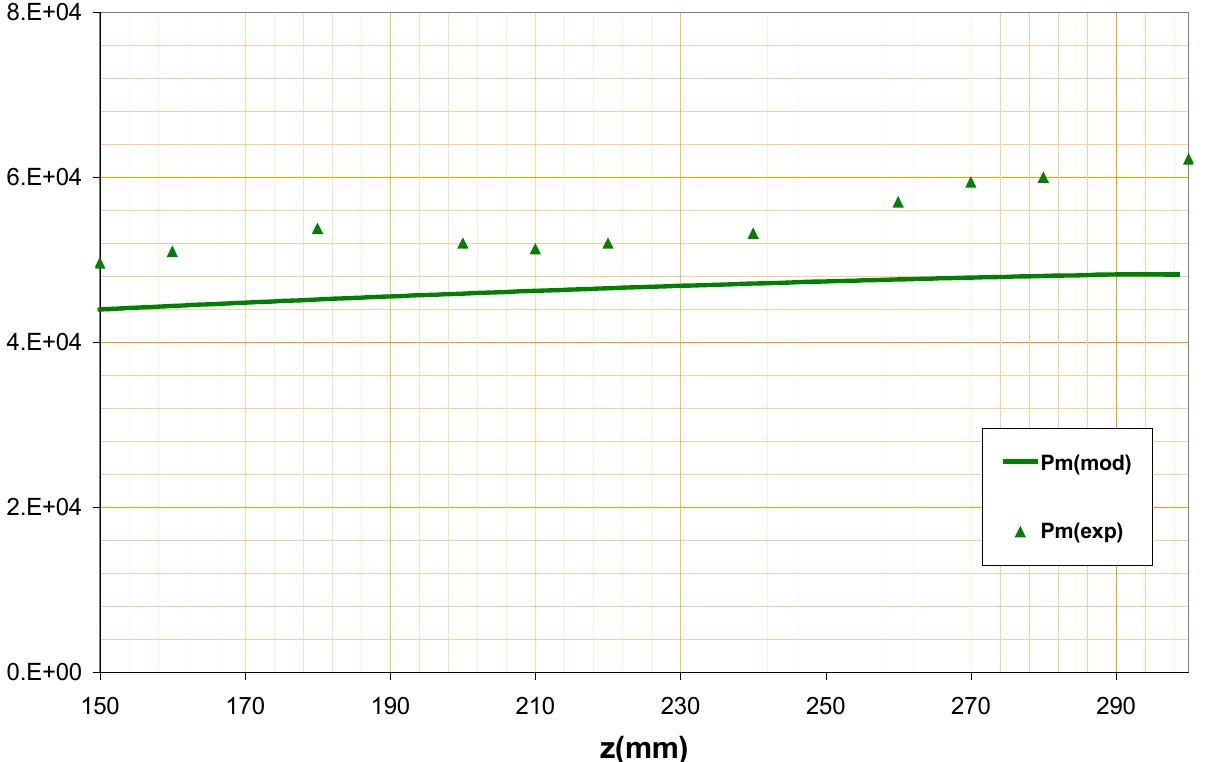

(None,
 'Figure 3-18 : Evaluation de la pression en fonction de la chambre de mélange (partie homogéne)')

In [241]:
# results[0].metadata.get("image_base64")
idx = 1
display_base64_image(results[idx].metadata.get("image_base64")),results[idx].metadata.get("caption")


In [252]:
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=qdrant,
    docstore=store,
    id_key=id_key,
)

In [271]:
import os
import json
import base64
from typing import List, Dict, Any, Optional, Tuple
from io import BytesIO
import pandas as pd
import time

# Ollama client
from ollama import Client

# For vector search (no HuggingFace dependency)
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class OllamaRAGChatbot:
    """
    Chatbot RAG qui utilise uniquement Ollama pour les embeddings et les réponses
    """
    
    def __init__(self, 
                 ollama_url: str = "http://localhost:11434",
                 ollama_model: str = "llama3.2",
                 ollama_embed_model: str = "mxbai-embed-large",
                 documents_path: str = None):
        """
        Initialise le chatbot RAG
        """
        # Configuration Ollama
        self.client = Client(host=ollama_url)
        self.ollama_model = ollama_model
        self.ollama_embed_model = ollama_embed_model
        
        # Structure pour stocker les documents en mémoire
        self.documents = []
        self.document_embeddings = []
        
        # Historique des conversations
        self.conversation_history = []
        
        # Charger les documents si un chemin est fourni
        if documents_path and os.path.exists(documents_path):
            self.load_documents(documents_path)
            
        print(f"Chatbot initialisé avec modèle: {ollama_model}")
        print(f"Utilisation de {ollama_embed_model} pour les embeddings")
    
    def load_documents(self, documents_path: str):
        """
        Charge les documents depuis un fichier JSON
        """
        with open(documents_path, 'r', encoding='utf-8') as f:
            self.documents = json.load(f)
        
        print(f"Chargement de {len(self.documents)} documents terminé")
        
        # Créer les embeddings pour les documents
        self._create_embeddings()
    
    def add_documents(self, documents: List[Dict]):
        """
        Ajoute des documents à la base
        """
        self.documents.extend(documents)
        self._create_embeddings_for_docs(documents, start_idx=len(self.documents) - len(documents))
        
    def _create_embeddings(self):
        """
        Crée les embeddings pour tous les documents
        """
        print("Création des embeddings pour tous les documents...")
        self.document_embeddings = []
        
        for idx, doc in enumerate(self.documents):
            if idx % 50 == 0:
                print(f"Traitement document {idx}/{len(self.documents)}")
            
            # Utiliser le contenu du document pour l'embedding
            content = doc.get("content", "")
            
            # Si pas de contenu, utiliser des métadonnées
            if not content:
                content = doc.get("caption", "")
            
            # Si toujours rien, passer au suivant
            if not content:
                self.document_embeddings.append(np.zeros(1024))  # Vecteur vide
                continue
                
            # Créer l'embedding avec Ollama
            try:
                embedding = self._get_ollama_embedding(content)
                self.document_embeddings.append(embedding)
            except Exception as e:
                print(f"Erreur lors de la création de l'embedding pour le document {idx}: {e}")
                self.document_embeddings.append(np.zeros(1024))  # Vecteur vide en cas d'erreur
                
        print(f"Création des embeddings terminée: {len(self.document_embeddings)} vecteurs créés")

    def _create_embeddings_for_docs(self, documents: List[Dict], start_idx: int = 0):
        """
        Crée les embeddings pour une liste spécifique de documents
        """
        for i, doc in enumerate(documents):
            idx = start_idx + i
            content = doc.get("content", doc.get("caption", ""))
            
            if content:
                try:
                    embedding = self._get_ollama_embedding(content)
                    
                    if idx < len(self.document_embeddings):
                        self.document_embeddings[idx] = embedding
                    else:
                        self.document_embeddings.append(embedding)
                except Exception as e:
                    print(f"Erreur d'embedding pour document {idx}: {e}")
                    if idx >= len(self.document_embeddings):
                        self.document_embeddings.append(np.zeros(1024))
            elif idx >= len(self.document_embeddings):
                self.document_embeddings.append(np.zeros(1024))
    
    def _get_ollama_embedding(self, text: str) -> np.ndarray:
        """
        Récupère l'embedding d'un texte via Ollama
        """
        try:
            response = self.client.embeddings(model=self.ollama_embed_model, prompt=text)
            embedding = response.get("embedding", [])
            return np.array(embedding)
        except Exception as e:
            print(f"Erreur lors de la récupération de l'embedding: {e}")
            # Réessayer après une pause
            time.sleep(1)
            try:
                response = self.client.embeddings(model=self.ollama_embed_model, prompt=text)
                embedding = response.get("embedding", [])
                return np.array(embedding)
            except:
                # En cas d'échec, retourner un vecteur vide
                return np.zeros(1024)
    
    def search_relevant_documents(self, query: str, k: int = 5) -> List[Dict]:
        """
        Recherche les documents pertinents en utilisant les embeddings Ollama
        """
        # Obtenir l'embedding de la requête
        query_embedding = self._get_ollama_embedding(query)
        
        # Calculer la similarité avec tous les documents
        if len(self.document_embeddings) == 0:
            return []
            
        similarities = []
        for doc_embedding in self.document_embeddings:
            if len(doc_embedding) > 0:  # Vérifier que l'embedding n'est pas vide
                similarity = cosine_similarity([query_embedding], [doc_embedding])[0][0]
                similarities.append(similarity)
            else:
                similarities.append(0.0)
        
        # Trier les documents par similarité
        if not similarities:
            return []
            
        top_indices = np.argsort(similarities)[-k:][::-1]  # Indices des k documents les plus similaires
        
        # Collecter les documents pertinents
        relevant_docs = []
        for idx in top_indices:
            if idx < len(self.documents):
                doc = self.documents[idx]
                doc_type = self._determine_doc_type(doc)
                relevant_docs.append({
                    "type": doc_type,
                    "content": doc.get("content", ""),
                    "metadata": {
                        "source": doc.get("source", ""),
                        "page_number": doc.get("page", ""),
                        "caption": doc.get("caption", ""),
                        "image_base64": doc.get("image_base64", ""),
                        "table_content": doc.get("table_data", "")
                    },
                    "relevance_score": similarities[idx]
                })
        
        return relevant_docs
    
    def _determine_doc_type(self, doc: Dict) -> str:
        """
        Détermine le type du document (texte, image, tableau)
        """
        if "image_base64" in doc:
            return "image"
        elif "table_data" in doc:
            return "table"
        else:
            return "text"
    
    def _build_context(self, relevant_docs: List[Dict]) -> Tuple[str, List[Dict], List[Dict]]:
        """
        Construit le contexte pour le LLM à partir des documents pertinents
        Retourne le contexte textuel, les images et les tableaux séparément
        """
        text_context = []
        images = []
        tables = []
        
        for doc in relevant_docs:
            doc_type = doc["type"]
            metadata = doc["metadata"]
            
            if doc_type == "text":
                # Ajouter le texte au contexte
                text = f"[Document: {metadata.get('source', 'Unknown')}]\n"
                if "page_number" in metadata:
                    text += f"[Page: {metadata.get('page_number')}]\n"
                text += doc["content"]
                text_context.append(text)
                
            elif doc_type == "image":
                # Collecter l'image avec sa description existante
                images.append({
                    "base64": metadata.get("image_base64"),
                    "description": doc["content"],  # Utilise la description existante
                    "caption": metadata.get("caption", ""),
                    "source": metadata.get("source", "Unknown"),
                    "page": metadata.get("page_number", "")
                })
                
                # Ajouter la description au contexte textuel
                text_context.append(
                    f"\n[Image de {metadata.get('source', 'Unknown')}, " + 
                    f"page {metadata.get('page_number', '')}]\n" +
                    f"Caption: {metadata.get('caption', '')}\n" +
                    f"Description: {doc['content']}\n"
                )
                
            elif doc_type == "table":
                # Collecter le tableau avec sa description existante
                tables.append({
                    "content": metadata.get("table_content"),
                    "description": doc["content"],  # Utilise la description existante
                    "caption": metadata.get("caption", ""),
                    "source": metadata.get("source", "Unknown"),
                    "page": metadata.get("page_number", "")
                })
                
                # Ajouter la description au contexte textuel
                text_context.append(
                    f"\n[Tableau de {metadata.get('source', 'Unknown')}, " +
                    f"page {metadata.get('page_number', '')}]\n" +
                    f"Caption: {metadata.get('caption', '')}\n" +
                    f"Description: {doc['content']}\n"
                )
        
        # Joindre tous les contextes texte
        full_context = "\n\n".join(text_context)
        
        return full_context, images, tables
    
    def chat(self, user_message: str, stream: bool = False, include_visuals: bool = True):
        """
        Répond à un message utilisateur en utilisant le RAG et Ollama
        
        Args:
            user_message: Question de l'utilisateur
            stream: Si True, affiche la réponse en streaming
            include_visuals: Si True, inclut les images et tableaux dans la réponse
        """
        # Garder une trace de l'historique
        self.conversation_history.append({"role": "user", "content": user_message})
        
        # 1. Rechercher les documents pertinents
        relevant_docs = self.search_relevant_documents(user_message, k=5)
        
        # 2. Construire le contexte pour le LLM
        context_text, images, tables = self._build_context(relevant_docs)
        
        # 3. Préparer le prompt avec le contexte
        system_prompt = """Tu es un assistant intelligent qui répond aux questions en utilisant uniquement 
        les informations fournies dans le contexte. Si tu ne trouves pas l'information dans le contexte, 
        dis simplement que tu ne sais pas. Lorsque tu mentionnes une image ou un tableau, décris
        brièvement son contenu en te basant sur les descriptions fournies."""
        
        prompt = f"""Contexte:
        {context_text}
        
        Question de l'utilisateur: {user_message}
        
        Réponds de façon concise et précise en citant les sources pertinentes.
        """
        
        # 4. Générer la réponse textuelle
        if stream:
            answer = self._stream_response(system_prompt, prompt)
        else:
            response = self.client.chat(
                model=self.ollama_model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": prompt}
                ]
            )
            answer = response["message"]["content"]
        
        # 5. Enregistrer la réponse dans l'historique
        self.conversation_history.append({"role": "assistant", "content": answer})
        
        # 6. Retourner la réponse avec les images et tableaux
        result = {
            "text_response": answer
        }
        
        if include_visuals:
            result["images"] = images if images else []
            result["tables"] = tables if tables else []
        
        return result
    
    def _stream_response(self, system_prompt: str, user_prompt: str):
        """
        Génère une réponse en mode streaming
        """
        response_stream = self.client.chat(
            model=self.ollama_model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            stream=True
        )
        
        full_response = ""
        for chunk in response_stream:
            if 'message' in chunk and 'content' in chunk['message']:
                content = chunk['message']['content']
                print(content, end="", flush=True)
                full_response += content
        
        print()  # Nouvelle ligne à la fin du streaming
        return full_response
    
    def display_image(self, image_base64: str, caption: str = ""):
        """
        Affiche une image à partir de sa représentation base64
        """
        try:
            from PIL import Image
            # Décodage de l'image base64
            image_data = base64.b64decode(image_base64)
            image = Image.open(BytesIO(image_data))
            
            # Selon l'environnement d'exécution:
            try:
                # Pour Jupyter/IPython
                from IPython.display import display
                print(f"Caption: {caption}")
                display(image)
            except ImportError:
                # Pour environnement non-Jupyter
                image.show()
            
            return True
        except Exception as e:
            print(f"Erreur lors de l'affichage de l'image: {e}")
            return False
        
    def save_documents(self, output_path: str):
        """
        Sauvegarde la base de documents dans un fichier JSON
        """
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(self.documents, f, ensure_ascii=False, indent=2)
        print(f"Documents sauvegardés dans {output_path}")


# Exemple d'utilisation:

# 1. Initialisation du chatbot
chatbot = OllamaRAGChatbot(
    ollama_model="llama3.2",
    ollama_embed_model="mxbai-embed-large"
)

# 2. Ajouter des documents (exemple)
def convert_documents_for_chatbot(title_chunks, images_with_caption, tables_with_caption):
    """
    Convertit vos données en format utilisable par le chatbot
    """
    all_docs = []
    
    # Convertir les chunks de texte
    for chunk in title_chunks:
        all_docs.append({
            "type": "text",
            "content": chunk.page_content,
            "source": chunk.metadata.get("source", ""),
            "page": chunk.metadata.get("page_numbers", "")
        })
    
    # Convertir les images
    for img in images_with_caption:
        all_docs.append({
            "type": "image",
            "content": img.get("description", ""),  # Description existante
            "caption": img.get("caption", ""),
            "source": img.get("source", ""),
            "page": img.get("page", ""),
            "image_base64": img.get("image_base64", "")
        })
    
    # Convertir les tableaux
    for table in tables_with_caption:
        all_docs.append({
            "type": "table",
            "content": table.get("description", ""),
            "caption": table.get("caption", ""),
            "source": table.get("source", ""),
            "page": table.get("page", ""),
            "table_data": table.get("table_data", "")
        })
    
    return all_docs

# Convertir et ajouter les documents
# docs = convert_documents_for_chatbot(title_chunks, images_with_caption, tables_with_caption)
# chatbot.add_documents(docs)

# 3. Interface en ligne de commande
def chat_cli():
    print("Assistant documentaire - Tapez 'exit' pour quitter")
    
    while True:
        user_input = input("\nVotre question: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            break
        
        # Mode streaming ou normal
        stream_mode = input("Mode streaming? (y/n): ").lower() == 'y'
        
        # Obtenir la réponse
        response = chatbot.chat(user_input, stream=stream_mode)
        
        # Si pas en mode streaming, afficher la réponse
        if not stream_mode:
            print("\nRéponse:")
            print(response["text_response"])
        
        # Afficher les images et tableaux
        if "images" in response and response["images"]:
            print("\nImages pertinentes:")
            for i, img in enumerate(response["images"]):
                print(f"[Image {i+1}] {img['caption']} (Source: {img['source']}, Page: {img['page']})")
                if input("Afficher cette image? (y/n): ").lower() == 'y':
                    chatbot.display_image(img["base64"], img["caption"])
        
        if "tables" in response and response["tables"]:
            print("\nTableaux pertinents:")
            for i, table in enumerate(response["tables"]):
                print(f"[Tableau {i+1}] {table['caption']} (Source: {table['source']}, Page: {table['page']})")
                print(f"Description: {table['description']}")
                
                if input("Afficher ce tableau? (y/n): ").lower() == 'y':
                    try:
                        print(table["content"])
                    except:
                        print("Impossible d'afficher le tableau.")

# Lancer l'interface CLI
# chat_cli()

Chatbot initialisé avec modèle: llama3.2
Utilisation de mxbai-embed-large pour les embeddings


In [275]:
chat_cli()

    
            


Assistant documentaire - Tapez 'exit' pour quitter
Un ejecteur est une machine ou un dispositif conçu pour éjecter, expulser ou déplacer quelque chose d'un endroit. Ce terme peut s'appliquer à divers domaines, tels que la mécanique, l'électronique et l'informatique.

Dans le contexte de l'électronique, un ejecteur est souvent utilisé pour libérer un média physique d'une machine ou d'un disque, par exemple, pour extraire une carte SD de son slot. (Source : Wikipedia)

En mécanique, un ejecteur peut être utilisé dans les machines à vapeur ou les locomotives pour expulser l'eau ou le fumier des cylindres ou des moteurs. (Source : Larousse)

En informatique, un ejecteur peut également désigner une interface graphique qui permet de sélectionner et de manipuler des éléments dans un programme ou un document. (Source : W3Schools)
Je ne peux pas afficher d'image directement. Cependant, je peux décrire brièvement le contenu de l'échangeur avec ejecteur :

Un échangeur est un dispositif qui perme

In [263]:
chat_cli()

Assistant documentaire - Tapez 'exit' pour quitter


In [253]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOllama(base_url="localhost:11434", model="llama3.2")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOllama(base_url="localhost:11434", model="llama3.2")
        | StrOutputParser()
    )
)

In [255]:
response = chain.invoke(
    "What is the ejector?"
)

print(response)

I don't see any context provided. Please share the relevant information, such as text, tables, or an image, and I'll do my best to answer your question about what the "ejector" refers to.


In [ ]:
import uuid
from qdrant_client import QdrantClient
from langchain_qdrant import QdrantVectorStore
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain_ollama import OllamaEmbeddings  # Vous pouvez remplacer par OpenAIEmbeddings si besoin
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.embeddings import OpenAIEmbeddings

# Initialiser le client Qdrant (ici, on suppose un serveur local sur le port 6333)
qdrant_client = QdrantClient(host="localhost", port=6333)

# Définir le nom de la collection
collection_name = "multi_modal_rag_07032025"
vector_size =1536
# Créer (ou recréer) la collection dans Qdrant

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config={"size": vector_size, "distance": "Cosine"},
)

# Choix de la fonction d'embedding :
# Pour utiliser OllamaEmbeddings :
embedding_function = OpenAIEmbeddings()
# Pour utiliser OpenAIEmbeddings, décommentez la ligne suivante et commentez la précédente :
# embedding_function = OpenAIEmbeddings()

# Créer la vectorstore avec QdrantVectorStore
vectorstore = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_function
)

# Couche de stockage en mémoire pour les documents parents
store = InMemoryStore()
id_key = "doc_id"

# Créer le retriever multi-vecteur
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# --- Ajout des textes ---
# (les variables texts et text_summaries doivent être définies au préalable)
doc_ids = [str(uuid.uuid4()) for _ in title_chunks]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]})
    for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, title_chunks)))
+ images_with_caption
# --- Ajout des tableaux ---
# (les variables tables et table_summaries doivent être définies au préalable)
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]})
    for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# --- Ajout des résumés d'images ---
# (les variables images et image_summaries doivent être définies au préalable)
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]})
    for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

["The 0D modeling approach simplifies global IC phenomena by considering only essential physics. It uses a global energy and mass balance to estimate injector characteristics. This model requires the consideration of an experimental closure law and has been previously implemented by various authors. The current approach starts from Deberne's 2000 model, which treats an injectant working with liquid central injection. Beithou also proposed a simplified OD model for an IC with vapor central injection, but it neglects the isobaric flow in the combustion chamber.",
 'Steam is supposed to undergo isentropic expansion until the primary pipe throat, then undergo adiabatic expansion in the divergent section, considering irreversibilities such as high velocity and possible oblique shock waves.',
 'Summary of table: A table containing a single entry with the content "condition critique de la vapeur" and metadata including source, title, and page numbers.',
 'Summary of table/text: Critical relax

In [114]:
from langchain_ollama import OllamaEmbeddings
embedding = OllamaEmbeddings(
                base_url="http://localhost:11434",
                model="mxbai-embed-large"
            )

from langchain_qdrant import QdrantVectorStore

qdrant = QdrantVectorStore.from_documents(
    final_chunks,
    embedding,
    url='http://localhost:6333',
    collection_name="my_documents",
)

AttributeError: 'dict' object has no attribute 'page_content'

11


In [6]:
# def get_tables_with_caption(documents):
#     tables_info = []
#     for idx, chunk in enumerate(documents):

#         if chunk.metadata.get("category") == "Table" or "table" in chunk.metadata.get("category", "").lower():

#             # Extraction du contenu textuel du tableau et de sa légende
#             payload = chunk.metadata.get("payload", {})
#             caption = payload.get("caption", "").strip()
#             print(chunk.metadata)
#             # Si aucune légende n'est trouvée, vérifier le bloc suivant
#             if not caption and idx + 1 < len(documents):
#                 next_chunk = documents[idx + 1]
#                 lower_text = next_chunk.page_content.lower()
#                 if any(keyword in lower_text for keyword in ["table", "tab.", "légende","tableau"]):
#                     caption = next_chunk.page_content.strip()


        
#             tables_info.append({
#                 "type": "table_with_caption",
#                 "table_data": chunk.page_content,  # Le contenu textuel du tableau
#                 "caption": caption
#             })
#     return tables_info
    

In [7]:
# get_tables_with_caption(documents)

In [10]:
idx= 7 
analyze_image(images_with_caption[idx].get("image_base64"),images_with_caption[idx].get("caption"))      

ConnectionError: Failed to connect to Ollama. Please check that Ollama is downloaded, running and accessible. https://ollama.com/download

In [ ]:
llm = OllamaLLM(base_url="http://localhost:11434", model="llama3.1")
def analyze_table(table_text: str, caption: str, context: str="",lang:str ="Français", prompt_base: str = ""):
    # Construction du prompt pour le tableau
    prompt = ""
    if caption:
        prompt += f"Caption of table : {caption}. "
    else:
        prompt += "Caption of table is empty no analyse of this table ignore the prompt"
    if context:
        prompt += f"Contexte : {context}. "
    
    if prompt_base:
        prompt = f"{prompt_base} {prompt}"
    else:
        prompt += f'Describe this table in detail and in {lang} avoid to say "Here is a detailed description" in {lang}.'
    prompt += prompt_base + " " + table_text
    response = llm.invoke(prompt)
    return response

In [ ]:
idx= 3 
analyze_table(tables_with_caption[idx].get("table_data"),tables_with_caption[idx].get("caption"),lang="english")      


'**Tableau-3-1: Numerical values at the inlet of the mixing chamber**\n\nThis table presents a set of numerical values representing various physical quantities at the entrance of the mixing chamber. The table includes six columns, each corresponding to a specific property:\n\n* **Grandeur**: This column indicates the name of the physical quantity being measured or calculated.\n* **M (kg/s)**: This represents the mass flow rate in kilograms per second. A value of 0.1 kg/s suggests that this is a relatively small-scale system or process, while 1.06 kg/s implies a larger capacity.\n* **u (m/s)**: This column shows the velocity in meters per second. The high value of 437 m/s for the vapor phase indicates a significant velocity component at the inlet of the mixing chamber.\n* **P; (bar)**: This represents the pressure in bars, with a decimal point separating the units. The values of 0.88 and 0.31 bar suggest that the system operates under relatively low pressures.\n* **T (°C)**: This indica

In [ ]:
tables_with_caption[3]


{'type': 'table_with_caption',
 'table_data': 'Grandeur M (kg/s) u, (m/s) P; (bar) T; (°C) pl (kg/m’) vapeur 0,1 437 0,88 96 0,62 liquide 1,06 12 0,31 23 998',
 'caption': "Tableau-3-1: Grandeurs numériques 4 l'entrée de la chambre de mélange"}

In [98]:
from langchain_ollama.llms import OllamaLLM

# Initialiser le modèle
llm = OllamaLLM(base_url="http://localhost:11434", model="llama3.2")

def analyze_table_streaming(table_text: str, caption: str,lang:str ="French", context: str="", prompt_base: str = ""):
    """
    Analyse un tableau avec LLaMA en mode streaming
    
    Args:
        table_text: Contenu textuel du tableau
        caption: Légende du tableau
        context: Contexte supplémentaire
        prompt_base: Instruction de base pour l'analyse
        
    Returns:
        Le texte complet généré
    """
    # Construction du prompt pour le tableau
    prompt = ""
    if caption:
        prompt += f"Caption du tableau : {caption}. "
    if context:
        prompt += f"Contexte : {context}. "

    if prompt_base:
        prompt = f"{prompt_base} {prompt}"
    else:
        prompt += f'Describe this table in detail and in {lang} avoid to say "Here is a detailed description" in {lang}.'
    prompt += prompt_base + " " + table_text
    
    # Utiliser le mode streaming
    response_stream = llm.stream(prompt)
    
    # Afficher la réponse en streaming et collecter le texte complet
    full_response = ""
    for chunk in response_stream:
        print(chunk, end="", flush=True)
        full_response += chunk
        
    print()  # Saut de ligne final
    return full_response

# Exemple d'utilisation
# result = analyze_table_streaming(
#     table_text="Colonne1 | Colonne2 | Colonne3\n10 | 20 | 30\n40 | 50 | 60",
#     caption="Tableau de données numériques",
#     context="Rapport financier Q3 2023",
#     prompt_base="Analyse ce tableau et donne-moi les principales tendances:"
# )
idx= 3
analyze_table_streaming(tables_with_caption[idx].get("table_data"),tables_with_caption[idx].get("caption"),lang="French")      


**Tableau-3-1 : Grandeurs numériques 4 à l'entrée de la chambre de mélange**

Ce tableau présente les données de grandeur numérique 4 collectées à l'entrée de la chambre de mélange, dans le cadre d'un expérimentation ou d'une simulation. Les données sont classifiées en fonction de leur nature (pluie ou vapeur) et présentent les paramètres suivants :

* **Grandeurs numériques 4** : La première colonne du tableau présente les valeurs des grandeurs numériques 4, qui sont définies par l'Association internationale pour la standardisation de la puissance (SI). Les grandesurs numériques 4 sont :
 + Masse volumique (pluie ou vapeur) : représentée par la colonne « pl » en kg/m³
 + Vitesse (vapeur) : représentée par la colonne « u » en m/s
 + Pression (vapeur) : représentée par la colonne « P » en barres
 + Température (pluie ou vapeur) : représentée par la colonne « T » en degrés Celsius

**Données**

Les données présentées dans le tableau sont les suivantes :

* **Vapeur** :
 + Masse volumique

"**Tableau-3-1 : Grandeurs numériques 4 à l'entrée de la chambre de mélange**\n\nCe tableau présente les données de grandeur numérique 4 collectées à l'entrée de la chambre de mélange, dans le cadre d'un expérimentation ou d'une simulation. Les données sont classifiées en fonction de leur nature (pluie ou vapeur) et présentent les paramètres suivants :\n\n* **Grandeurs numériques 4** : La première colonne du tableau présente les valeurs des grandeurs numériques 4, qui sont définies par l'Association internationale pour la standardisation de la puissance (SI). Les grandesurs numériques 4 sont :\n + Masse volumique (pluie ou vapeur) : représentée par la colonne « pl » en kg/m³\n + Vitesse (vapeur) : représentée par la colonne « u » en m/s\n + Pression (vapeur) : représentée par la colonne « P » en barres\n + Température (pluie ou vapeur) : représentée par la colonne « T » en degrés Celsius\n\n**Données**\n\nLes données présentées dans le tableau sont les suivantes :\n\n* **Vapeur** :\n +

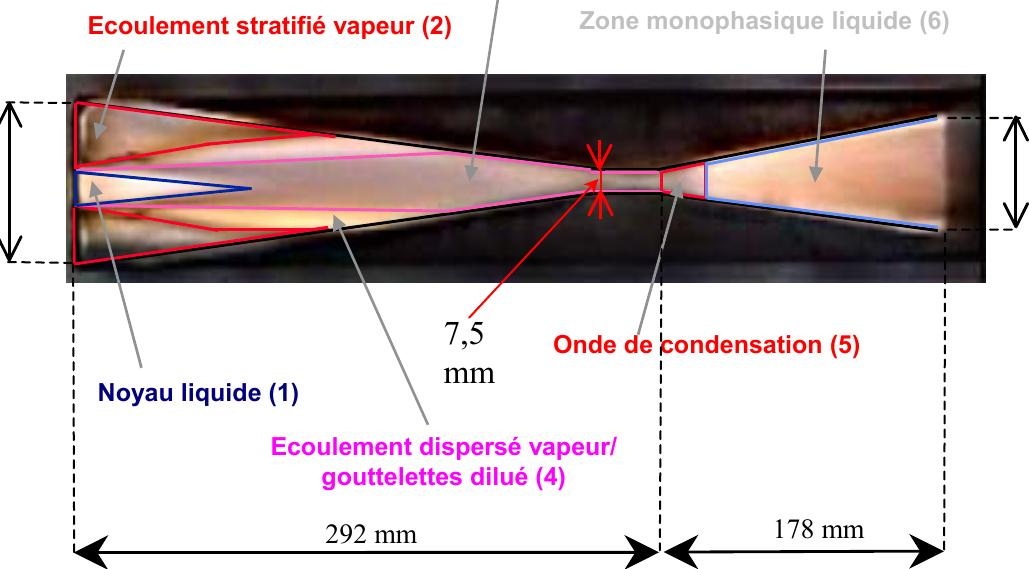

Figure 3-7 : Définition des zones d'écoulements dans la chambre de mélange


In [54]:
idx = 7
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))
display_base64_image(images_with_caption[idx].get('image_base64'))
print(images_with_caption[idx].get('caption'))

In [ ]:
from ollama import Client
client = Client(host='http://localhost:11434')


# Fonction pour analyser une image en mode streaming
def analyze_image_streaming(image_data, caption: str, context: str="", prompt_base: str = ""):
    prompt = ""
    if caption:
        prompt += f"Caption of image : {caption}. "
    if context:
        prompt += f"Contexte : {context}. "
        
    if prompt_base:
        prompt = f"{prompt_base} {prompt}"
    else:
        prompt += "Décris cette image en détail."
    
    # Utilise le paramètre stream=True pour obtenir une réponse en streaming
    response_stream = client.chat(
        model="llama3.2-vision",
        messages=[
            {"role": "user", "content": prompt, "images": [image_data]}
        ],
        stream=True  # Activer le streaming
    )
    
    # Fonction pour traiter et afficher la réponse au fur et à mesure
    full_response = ""
    for chunk in response_stream:
        if 'message' in chunk and 'content' in chunk['message']:
            content = chunk['message']['content']
            print(content, end="", flush=True)  # Afficher sans saut de ligne et forcer le flush
            full_response += content
    
    return full_response  # Retourne aussi la réponse complète


# Exemple d'utilisation:
# with open('path/to/image.jpg', 'rb') as f:
#     image_data = f.read()
#     
# analyze_image_streaming(
#     image_data=image_data,
#     caption="Une photographie de montagne",
#     context="Document sur les paysages alpins"
# )

In [55]:
idx= 7
analyze_image_streaming(images_with_caption[idx].get("image_base64"),images_with_caption[idx].get("caption"),lang="francais")    

Caption of image : Figure 3-7 : Définition des zones d'écoulements dans la chambre de mélange. Décris cette image en détail. en francais.
The image provided is a diagram that illustrates the flow zones in a mixing chamber, labeled as Figure 3-7. This diagram provides an informative visualization of the different regions within this specialized device.

**Chambre de Mélange**

*   The chamber measures 178mm in length and 292mm in width.
*   It features a distinctive triangular shape with rounded edges.

**Zones d'écoulements**

The image identifies six distinct zones:

1.  **Noyau liquide (Liquid Core)**: This zone is situated at the center of the chamber, representing the core area where liquid fuel and oxidizer are combined.
2.  **Ecoulement stratifié vapeur (Stratified Vapor Flow)**: Positioned on either side of the liquid core, this zone features a layered structure with alternating layers of vapor and gas.
3.  **Onde de condensation (Condensation Wave)**: This zone is located at th

"The image provided is a diagram that illustrates the flow zones in a mixing chamber, labeled as Figure 3-7. This diagram provides an informative visualization of the different regions within this specialized device.\n\n**Chambre de Mélange**\n\n*   The chamber measures 178mm in length and 292mm in width.\n*   It features a distinctive triangular shape with rounded edges.\n\n**Zones d'écoulements**\n\nThe image identifies six distinct zones:\n\n1.  **Noyau liquide (Liquid Core)**: This zone is situated at the center of the chamber, representing the core area where liquid fuel and oxidizer are combined.\n2.  **Ecoulement stratifié vapeur (Stratified Vapor Flow)**: Positioned on either side of the liquid core, this zone features a layered structure with alternating layers of vapor and gas.\n3.  **Onde de condensation (Condensation Wave)**: This zone is located at the top of the chamber, where condensed droplets form due to the cooling effect caused by rapid expansion.\n4.  **Ecoulement d

In [49]:
# Afficher toutes les catégories uniques dans le document
categories = set()
category_counts = {}

for doc in documents:
    category = doc.metadata.get("category", "None")
    categories.add(category)
    
    # Compter aussi le nombre d'occurrences de chaque catégorie
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Afficher les résultats
print("Catégories uniques trouvées:")
for category in sorted(categories):
    print(f"- {category}: {category_counts[category]} éléments")

# Afficher quelques exemples pour chaque catégorie
print("\nExemples pour chaque catégorie:")
examples = {}

for doc in documents:
    category = doc.metadata.get("category", "None")
    if category not in examples:
        # Tronquer le contenu s'il est trop long
        content = doc.page_content
        if len(content) > 100:
            content = content[:100] + "..."
        examples[category] = content
        print(f"\n{category}:\n{content}")
    
    # Arrêter une fois qu'on a un exemple de chaque catégorie
    if len(examples) == len(categories):
        break

Catégories uniques trouvées:
- FigureCaption: 28 éléments
- Formula: 187 éléments
- Header: 78 éléments
- Image: 27 éléments
- ListItem: 159 éléments
- NarrativeText: 460 éléments
- Table: 11 éléments
- Title: 109 éléments
- UncategorizedText: 86 éléments

Exemples pour chaque catégorie:

NarrativeText:
3. CHAPITRE 3:

UncategorizedText:
92

Header:
Chapitre 3 : Modélisation LD des injecteurs condenseurs

Title:
3-1 MODELISATION 0D DE LIC

Formula:
My (hy + 0,5uiy )+ My, (hy, + 0,5u2, = M tal (hs, + 0,5u2, ) My +My = Mga (3-1) total PaSs1 U3, =

ListItem:
la tuyére primaire (1) ;

Image:
dd) (3) 4) G6)

FigureCaption:
Figure 3-1 : Découpage de l'injecteur en 5 modules pour la modélisation globale

Table:
Définition Coefficient de détente polytropique | Coefficient de perte de charge dans dans la tuyére ...


In [48]:
documents[15]

Document(metadata={'source': 'F:\\Dev\\Rag\\Rag_Modeling\\document\\11_chapitre3.pdf', 'detection_class_prob': 0.8323268294334412, 'coordinates': {'points': ((201.26402282714844, 1886.039306640625), (201.26402282714844, 1919.756103515625), (620.4884033203125, 1919.756103515625), (620.4884033203125, 1886.039306640625)), 'system': 'PixelSpace', 'layout_width': 1653, 'layout_height': 2339}, 'last_modified': '2007-03-06T16:04:59', 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 2, 'file_directory': 'F:\\Dev\\Rag\\Rag_Modeling\\document', 'filename': '11_chapitre3.pdf', 'category': 'ListItem', 'element_id': '3210454e1263ced051d55327eb9d5340'}, page_content="l'onde de condensation (4) ;")

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from langchain_core.output_parsers import StrOutputParser
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is. All summay will be in English

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

model = OllamaLLM(base_url="172.20.48.1:11434",
    model="llama3.2")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()